In [15]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
import warnings
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 22})

In [16]:
combined = pd.read_pickle("./data/combined.pkl")
maize = combined[(combined['yield'].notna() )& (combined['cropname']=="Maize")]
counts = maize.groupby(['country']).size().reset_index(name="counts")
maize = maize.merge(counts)
maize_18 = maize[maize['counts']>17]
maize_18['yield'] = maize_18['yield']/10000

In [17]:
corrdf = maize_18.groupby(['country']).apply(lambda d:pd.Series(stats.pearsonr(d['csif'], d['yield']), index=["corr", "pval"])).reset_index()
corrdf['pval']= round(corrdf['pval'],4)
corrdf['abs(corr)'] = abs(corrdf['corr'])

In [18]:
bestcorrs= corrdf.loc[corrdf.groupby('country')["corr"].idxmax()].sort_values("corr", ascending=False)[0:5]
bestcorrs['corr']=round(bestcorrs['corr'],2)
bestcorrs_index = list(bestcorrs.country.values)

worstcorrs= corrdf.loc[corrdf.groupby('country')["corr"].idxmax()].sort_values("corr", ascending=True)[0:5]
worstcorrs['corr']=round(worstcorrs['corr'],2)
worstcorrs_index = list(worstcorrs.country.values)

In [19]:
fao = pd.read_csv("./data/faostat_maize_flags.csv")[['Area', 'Year', 'Flag Description']]
fao = fao[(fao['Year']>1999) & (fao['Year']<2020) ]
fao = fao[fao['Flag Description']=="Estimated value"][['Area', 'Year']]

In [20]:
def twin_lineplot(x,y,color,**kwargs):
    ax = plt.twinx()
    sns.lineplot(x=x,y=y,color=color, ax=ax)

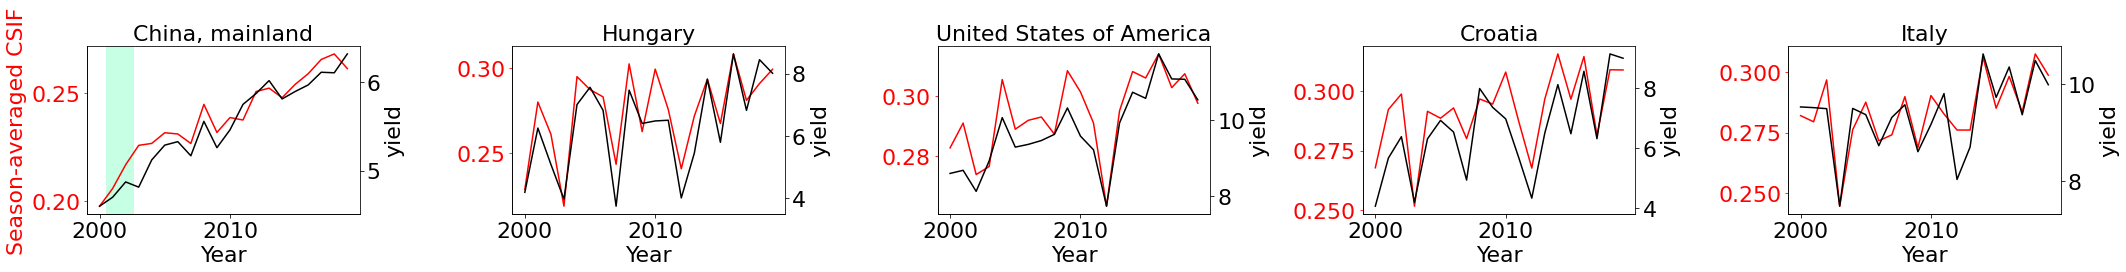

In [21]:
df = maize_18[maize_18['country'].isin(bestcorrs_index)]
df.country = df.country.astype("category")
df.country = df.country.cat.set_categories(bestcorrs_index)
df = df.sort_values(["country"])

flags = fao[fao["Area"].isin(bestcorrs_index)]

g = sns.FacetGrid(df, col="name", col_wrap = 5, sharey=False, height=4, aspect=1.5)

for ax in g.axes.flat:
    ax.set_ylabel("Season-averaged CSIF", color="red")
    ax.tick_params(axis='y', colors='red')

g.set_titles(col_template='{col_name}')
g.set_axis_labels("Year", "Season-averaged CSIF")

gaxes= pd.DataFrame({"axes": str(g.axes).split("\n")})

fl = flags.values.tolist()

for country, year in fl:
    idx = int(gaxes[gaxes['axes'].str.contains(country)].index.values)
    g.axes[idx].axvline(year, color="#c6ffe3",linewidth=15, alpha=1)

g.map(sns.lineplot, "year", "csif", color="red", ci=None)
g.map(twin_lineplot, 'year', 'yield', color="black")

g.set_titles(col_template='{col_name}')
g.set_axis_labels("Year", "Season-averaged CSIF")


plt.show()
g.savefig("./plots/bestcorrs_ts_flag.pdf")

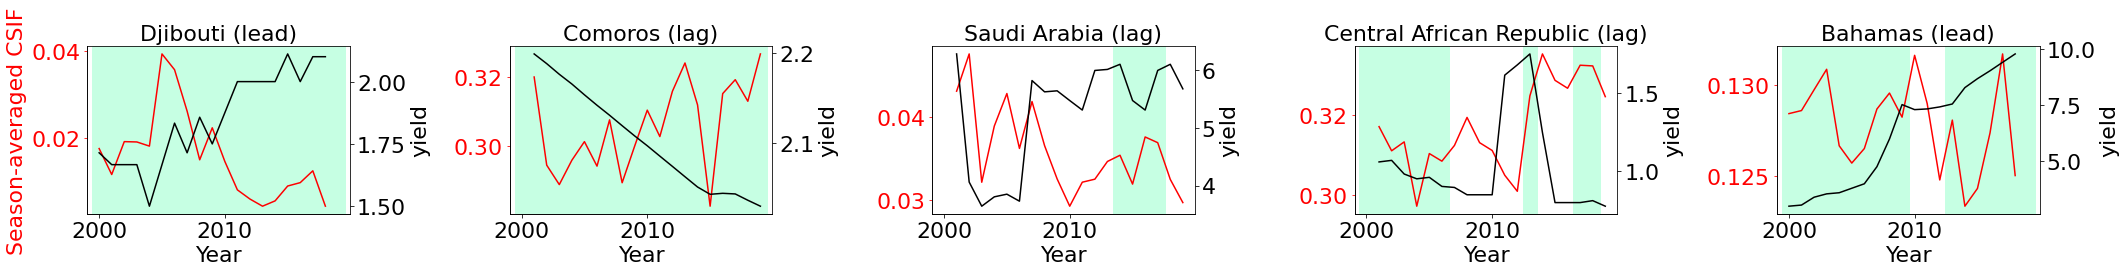

In [22]:
df = maize_18[maize_18['country'].isin(worstcorrs_index)]
df.country = df.country.astype("category")
df.country = df.country.cat.set_categories(worstcorrs_index)
df = df.sort_values(["country"])

flags = fao[fao["Area"].isin(worstcorrs_index)]

g = sns.FacetGrid(df, col="name", col_wrap = 5, sharey=False, height=4, aspect=1.5)

for ax in g.axes.flat:
    ax.set_ylabel("Season-averaged CSIF", color="red")
    ax.tick_params(axis='y', colors='red')

g.set_titles(col_template='{col_name}')
g.set_axis_labels("Year", "Season-averaged CSIF")

gaxes= pd.DataFrame({"axes": str(g.axes).split("\n")})

fl = flags.values.tolist()

for country, year in fl:
    idx = int(gaxes[gaxes['axes'].str.contains(country)].index.values)
    g.axes[idx].axvline(year, color="#c6ffe3",linewidth=15, alpha=1)

g.map(sns.lineplot, "year", "csif", color="red", ci=None)
g.map(twin_lineplot, 'year', 'yield', color="black")

g.set_titles(col_template='{col_name}')
g.set_axis_labels("Year", "Season-averaged CSIF")


plt.show()
g.savefig("./plots/worstcorrs_ts_flag.pdf")

# map

In [9]:
c= ['Bosnia and Herz.', 'Central African Rep.',"Côte d'Ivoire", 'Dem. Rep. Congo', "eSwatini", "Laos", 'Macedonia', 'Moldova', 'North Korea', 
'Russia','South Korea', 'Syria', 'Tanzania', 'Vietnam', "United Kingdom", "Dominican Rep.", "China", "Iran", "S. Sudan"]

mustfix = ["Bosnia and Herzegovina", "Central African Republic", "Côte d'Ivoire", "Democratic Republic of the Congo","Eswatini", "Lao People's Democratic Republic",
           "North Macedonia", "Republic of Moldova", "Democratic People's Republic of Korea", "Russian Federation", "Republic of Korea", 
           "Syrian Arab Republic", "United Republic of Tanzania", "Viet Nam", "United Kingdom of Great Britain and Northern Ireland", "Dominica", "China, mainland", "Iran (Islamic Republic of)" , "South Sudan"]

changes = pd.DataFrame({"country": mustfix, "fixed":c})

countries = gpd.read_file(
               gpd.datasets.get_path("naturalearth_lowres"))
countries = countries.rename({"name":"country"}, axis=1)
mollweide_proj = '+proj=moll +lon_0=0'

countries = countries.to_crs(mollweide_proj)
countries = countries[countries['continent']!= "Antarctica"]


In [10]:
fao = pd.read_csv("./data/faostat_maize_flags.csv")[['Area', 'Year', 'Flag Description']]
fao = fao[(fao['Year']>1999) & (fao['Year']<2020) ]
fao = fao[fao['Flag Description']=="Estimated value"][['Area', 'Year']]
fao['flag'] = 1
faomap = fao.copy().rename(columns={'Area': 'country'})

faomap = faomap.merge(changes, how="left")
faomap.loc[faomap.fixed.notnull(), 'country'] = faomap.fixed
faomap = faomap.groupby('country').sum('flag')['flag'].reset_index()

In [11]:
natnames= np.unique(countries['country'])
faonames = np.unique(faomap['country'])

set1 = set(natnames)
set2 = set(faonames)
similar = sorted(set1.intersection(set2))
only_in_list1 = sorted(set1.difference(set2))
only_in_list2 = sorted(set2.difference(set1))

# print("Similar elements:", similar, '\n')
# print("Only in natural earth:", only_in_list1, '\n')
# print("Only in fao flags:", only_in_list2, '\n')


In [12]:
colors = ["#fdd7de", "red", "darkred"]
custom_cmap = LinearSegmentedColormap.from_list("pink_to_darkred", colors)

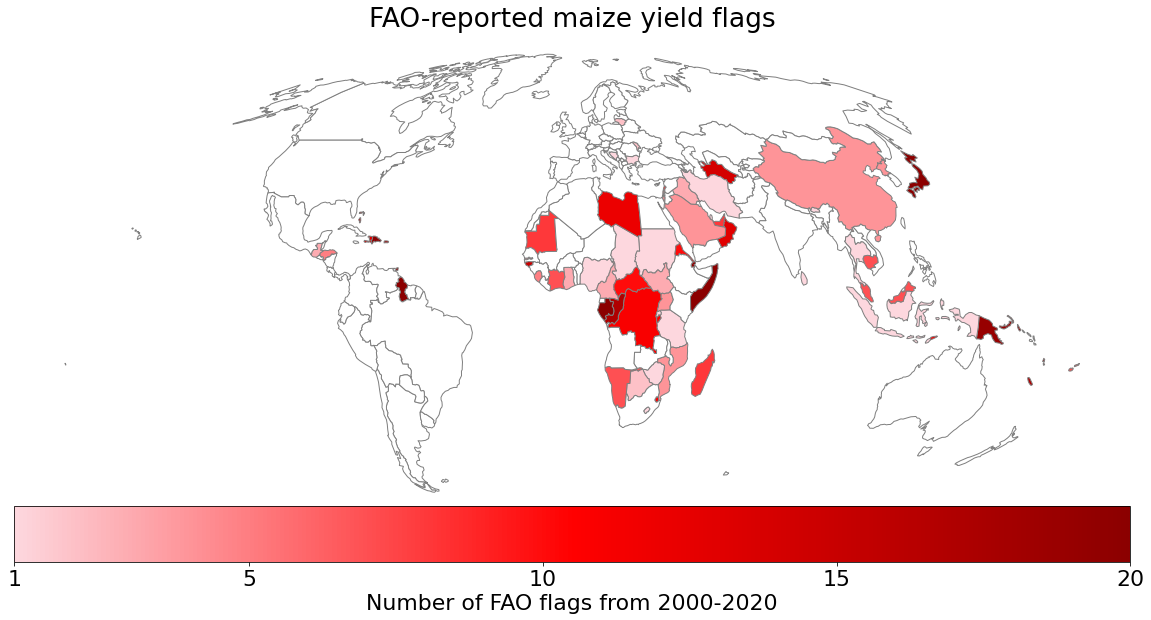

In [24]:
hm = countries.merge(faomap, on="country", how="left")
hm['flag']= pd.to_numeric(hm['flag'])#.fillna(0)

fig, ax = plt.subplots(1, 1, figsize=(20,15)) 

def integer_formatter(x, pos):
    return f"{int(x)}"

hm.plot(column="flag",legend=True, cmap=custom_cmap, edgecolor="gray", vmin=1,
               legend_kwds={'label': "Number of FAO flags from 2000-2020",
                        'orientation': "horizontal",
                           'pad': -0.01,
                            'ticks': [1,5,10, 15,20],
                            'format': FuncFormatter(integer_formatter)}, 
                 missing_kwds={'color': 'white'}, ax=ax)


plt.axis('off')
plt.title('FAO-reported maize yield flags')
plt.savefig("./plots/flags_map.pdf", bbox_inches="tight")